In [1]:
import h5py
import numpy as np
import pandas as pd 

import fastdtw
import scipy.spatial.distance as sd

from scipy import ndimage 
from scipy.cluster import hierarchy 
from scipy.spatial import distance_matrix 
from sklearn import manifold, datasets 
from sklearn.cluster import AgglomerativeClustering

import matplotlib.pyplot as plt
import seaborn as sns 
plt.rcParams["figure.figsize"] = [16,9]
sns.set_style('whitegrid')

GRID_SIZE = 0.06
LOWER_LAMBDA = 6472.5
UPPER_LAMBDA = 6740
PLOT_MASK = range(1475,1550)

In [215]:
hf_spec = h5py.File("/home/pravn/Dropbox/Masters/masters-thesis-from-nut-data/resampled_emission_spectra.h5", "r")
hf_grid = h5py.File("/home/pravn/Dropbox/Masters/masters-thesis-from-nut-data/wl_grid.h5", "r")

wl_grid = np.array(hf_grid["wl_grid"])
df = pd.DataFrame(hf_spec["spectra"])

In [216]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,4449,4450,4451,4452,4453,4454,4455,4456,4457,4458
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [217]:
hf_spec.close()
hf_grid.close()

In [218]:
df_masked = df.loc[:,PLOT_MASK]
df_masked_np = df_masked.to_numpy()

In [6]:
def my_fastdtw(spec1, spec2):
    return fastdtw.fastdtw(spec1, spec2)[0]

In [6]:
#Reads saved distances
#hf_dtwdistance = h5py.File("/home/pravn/Dropbox/Masters/Research Data/dtw_distances_halpha.h5","r")

In [7]:
#distance_matrix_square_form= np.array(hf_dtwdistance["dtw_distance"])

In [8]:
#hf_dtwdistance.close()

In [7]:
#Calculates dtw distance ~19mins run time on Praveen-Ryzen-Pop
distance_matrix = sd.pdist(df_masked_np, my_fastdtw) #O(N^2)

In [8]:
#Creates square form of calculated distances 
distance_matrix_square_form = sd.squareform(distance_matrix)

In [9]:
#Saves distances to file - only do this once
#hf_dtwdistance = h5py.File("/home/pravn/Dropbox/Masters/Research Data/dtw_distances_halpha.h5","w")

In [9]:
#hf_dtwdistance.create_dataset("dtw_distance", data=distance_matrix_square_form)
#hf_dtwdistance.close()

NameError: name 'hf_dtwdistance' is not defined

In [9]:
distance_matrix_square_form

array([[ 0.        ,  3.0977969 ,  8.2318713 , ...,  1.64667516,
         1.3882707 ,  4.04934201],
       [ 3.0977969 ,  0.        , 10.59016601, ...,  4.2460357 ,
         4.68924662,  6.73320981],
       [ 8.2318713 , 10.59016601,  0.        , ...,  6.65299951,
         8.03202775,  3.33671064],
       ...,
       [ 1.64667516,  4.2460357 ,  6.65299951, ...,  0.        ,
         1.38817553,  2.69484773],
       [ 1.3882707 ,  4.68924662,  8.03202775, ...,  1.38817553,
         0.        ,  3.4286624 ],
       [ 4.04934201,  6.73320981,  3.33671064, ...,  2.69484773,
         3.4286624 ,  0.        ]])

In [10]:
def distance_cost_plot(distances):
    im = plt.imshow(distances, interpolation='nearest', cmap='Blues') 
    plt.gca().invert_yaxis()
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid()
    plt.colorbar();

In [11]:
distance_matrix_square_form[:,0]

array([0.        , 3.0977969 , 8.2318713 , ..., 1.64667516, 1.3882707 ,
       4.04934201])

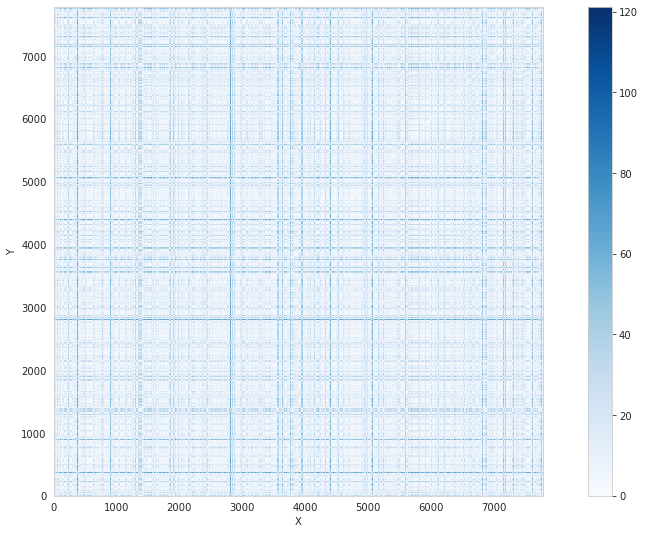

In [12]:
#distance_cost_plot(distance_matrix_square_form[0:100:,0:100])
distance_cost_plot(distance_matrix_square_form)

In [257]:
agglom = AgglomerativeClustering(n_clusters = 10, linkage = 'complete', affinity='precomputed')
#agglom = AgglomerativeClustering(n_clusters = 8, linkage = 'complete', affinity='precomputed') #208 P Cygni
#agglom = AgglomerativeClustering(n_clusters = 11, linkage = 'ward', affinity='euclidean')
agglom.fit(distance_matrix_square_form)
agglom.labels_

array([3, 8, 2, ..., 3, 3, 3])

In [258]:
from sklearn.metrics import silhouette_samples, silhouette_score

In [259]:
score = silhouette_score(df_masked_np, agglom.labels_)
print(score)

0.12319993254040176


In [219]:
old_names = df_masked.columns.tolist()

In [220]:
new_names = wl_grid[PLOT_MASK].tolist()

In [221]:
col_rename_dict = {i:j for i,j in zip(old_names, new_names)}

In [222]:
df_masked.rename(columns=col_rename_dict, inplace=True)

In [223]:
df_masked

,6561.00,6561.06,6561.12,6561.18,6561.24,6561.30,6561.36,6561.42,6561.48,6561.54,...,6564.90,6564.96,6565.02,6565.08,6565.14,6565.20,6565.26,6565.32,6565.38,6565.44
0,0.791232,0.799116,0.798513,0.789936,0.770570,0.747840,0.750200,0.778579,0.805557,0.818449,...,0.798908,0.787328,0.786379,0.795869,0.800229,0.788336,0.781923,0.799863,0.835885,0.842837
1,0.792635,0.802788,0.812055,0.812980,0.820564,0.820653,0.802152,0.816169,0.836336,0.844031,...,0.834167,0.836624,0.833515,0.842665,0.842630,0.822573,0.815889,0.823465,0.822819,0.823745
2,0.933980,0.933016,0.938823,0.940059,0.924773,0.907661,0.921055,0.954028,0.965563,0.947565,...,0.935452,0.955855,0.963570,0.961132,0.948284,0.936598,0.938312,0.942492,0.946763,0.950273
3,1.016790,1.033717,1.039141,1.053989,1.071330,1.068635,1.053506,1.034933,1.029725,1.013231,...,1.059578,1.066814,1.051114,1.045202,1.061199,1.052639,1.056661,1.036873,1.035144,1.027276
4,1.068419,1.064418,1.059543,1.045539,1.045996,1.074062,1.101389,1.097221,1.074829,1.057252,...,0.956748,0.948488,0.951768,0.963281,0.994941,1.033656,1.060059,1.077753,1.082559,1.075347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7781,0.979460,0.979947,0.992501,0.989477,0.973512,0.967220,0.973822,0.969585,0.959854,0.962128,...,0.983729,0.992850,1.004913,1.021605,1.029605,1.020435,1.005490,1.008604,1.042151,1.070625
7782,0.863882,0.848471,0.843037,0.840001,0.837331,0.834296,0.837569,0.835818,0.814332,0.811529,...,0.881433,0.880143,0.875100,0.903360,0.913392,0.900255,0.892303,0.890207,0.885781,0.886356
7783,0.774460,0.797341,0.842996,0.851695,0.832578,0.821339,0.809885,0.813631,0.819904,0.802070,...,0.771875,0.759515,0.782272,0.813831,0.816796,0.807716,0.802482,0.803715,0.810537,0.797218
7784,0.793960,0.789796,0.748887,0.756238,0.757121,0.718977,0.737649,0.747256,0.735109,0.722338,...,0.798911,0.804237,0.811593,0.803251,0.802970,0.821207,0.803905,0.772992,0.781017,0.804208


In [224]:
df_masked["label"] = pd.Series(agglom.labels_, index = df_masked.index)

In [225]:
df_masked

,6561.00000000059,6561.060000000591,6561.120000000591,6561.1800000005915,6561.240000000592,6561.300000000592,6561.360000000593,6561.420000000593,6561.4800000005935,6561.540000000594,...,6564.960000000617,6565.020000000617,6565.0800000006175,6565.140000000618,6565.200000000618,6565.260000000619,6565.320000000619,6565.3800000006195,6565.44000000062,label
0,0.791232,0.799116,0.798513,0.789936,0.770570,0.747840,0.750200,0.778579,0.805557,0.818449,...,0.787328,0.786379,0.795869,0.800229,0.788336,0.781923,0.799863,0.835885,0.842837,0
1,0.792635,0.802788,0.812055,0.812980,0.820564,0.820653,0.802152,0.816169,0.836336,0.844031,...,0.836624,0.833515,0.842665,0.842630,0.822573,0.815889,0.823465,0.822819,0.823745,1
2,0.933980,0.933016,0.938823,0.940059,0.924773,0.907661,0.921055,0.954028,0.965563,0.947565,...,0.955855,0.963570,0.961132,0.948284,0.936598,0.938312,0.942492,0.946763,0.950273,4
3,1.016790,1.033717,1.039141,1.053989,1.071330,1.068635,1.053506,1.034933,1.029725,1.013231,...,1.066814,1.051114,1.045202,1.061199,1.052639,1.056661,1.036873,1.035144,1.027276,3
4,1.068419,1.064418,1.059543,1.045539,1.045996,1.074062,1.101389,1.097221,1.074829,1.057252,...,0.948488,0.951768,0.963281,0.994941,1.033656,1.060059,1.077753,1.082559,1.075347,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7781,0.979460,0.979947,0.992501,0.989477,0.973512,0.967220,0.973822,0.969585,0.959854,0.962128,...,0.992850,1.004913,1.021605,1.029605,1.020435,1.005490,1.008604,1.042151,1.070625,4
7782,0.863882,0.848471,0.843037,0.840001,0.837331,0.834296,0.837569,0.835818,0.814332,0.811529,...,0.880143,0.875100,0.903360,0.913392,0.900255,0.892303,0.890207,0.885781,0.886356,0
7783,0.774460,0.797341,0.842996,0.851695,0.832578,0.821339,0.809885,0.813631,0.819904,0.802070,...,0.759515,0.782272,0.813831,0.816796,0.807716,0.802482,0.803715,0.810537,0.797218,0
7784,0.793960,0.789796,0.748887,0.756238,0.757121,0.718977,0.737649,0.747256,0.735109,0.722338,...,0.804237,0.811593,0.803251,0.802970,0.821207,0.803905,0.772992,0.781017,0.804208,1


In [226]:
df_sobject_ids = pd.read_csv("/home/pravn/Dropbox/Masters/masters-thesis-from-nut-data/GALAH_DR3_cotar_best_emission_candidates.csv", header=None)
df_sobject_ids.columns = ["sobject_id"]
df_masked = pd.concat([df_masked, df_sobject_ids], axis=1)
cols = df_masked.columns.tolist()
cols = cols[-1:] + cols[:-1]
df_masked = df_masked[cols]

In [227]:
sobject_ids = df_sobject_ids["sobject_id"].to_numpy().tolist()

In [228]:
df_masked.head()

,sobject_id,6561.00000000059,6561.060000000591,6561.120000000591,6561.1800000005915,6561.240000000592,6561.300000000592,6561.360000000593,6561.420000000593,6561.4800000005935,...,6564.960000000617,6565.020000000617,6565.0800000006175,6565.140000000618,6565.200000000618,6565.260000000619,6565.320000000619,6565.3800000006195,6565.44000000062,label
0,131116000501262,0.791232,0.799116,0.798513,0.789936,0.770570,0.747840,0.750200,0.778579,0.805557,...,0.787328,0.786379,0.795869,0.800229,0.788336,0.781923,0.799863,0.835885,0.842837,0
1,131116000501383,0.792635,0.802788,0.812055,0.812980,0.820564,0.820653,0.802152,0.816169,0.836336,...,0.836624,0.833515,0.842665,0.842630,0.822573,0.815889,0.823465,0.822819,0.823745,1
2,131116001001213,0.933980,0.933016,0.938823,0.940059,0.924773,0.907661,0.921055,0.954028,0.965563,...,0.955855,0.963570,0.961132,0.948284,0.936598,0.938312,0.942492,0.946763,0.950273,4
3,131116001001379,1.016790,1.033717,1.039141,1.053989,1.071330,1.068635,1.053506,1.034933,1.029725,...,1.066814,1.051114,1.045202,1.061199,1.052639,1.056661,1.036873,1.035144,1.027276,3
4,131118002401234,1.068419,1.064418,1.059543,1.045539,1.045996,1.074062,1.101389,1.097221,1.074829,...,0.948488,0.951768,0.963281,0.994941,1.033656,1.060059,1.077753,1.082559,1.075347,8


In [229]:
df_masked["label"].value_counts()

0     2022
4     1615
1     1520
7      916
3      477
5      459
9      371
8      159
6      134
10      73
2       40
Name: label, dtype: int64

Int64Index([ 373, 1343, 1896, 2045, 2428, 2480, 2506, 2539, 2786, 2804, 3699,
            3901, 3915, 3926, 4046, 4294, 4372, 4673, 4689, 4699, 4708, 4986,
            5213, 5266, 5753, 5841, 6028, 6060, 6325, 6326, 6822, 7278, 7323,
            7336, 7406, 7416, 7570, 7655, 7723, 7725],
           dtype='int64')


Text(6562.78, 2.5, 'Hα')

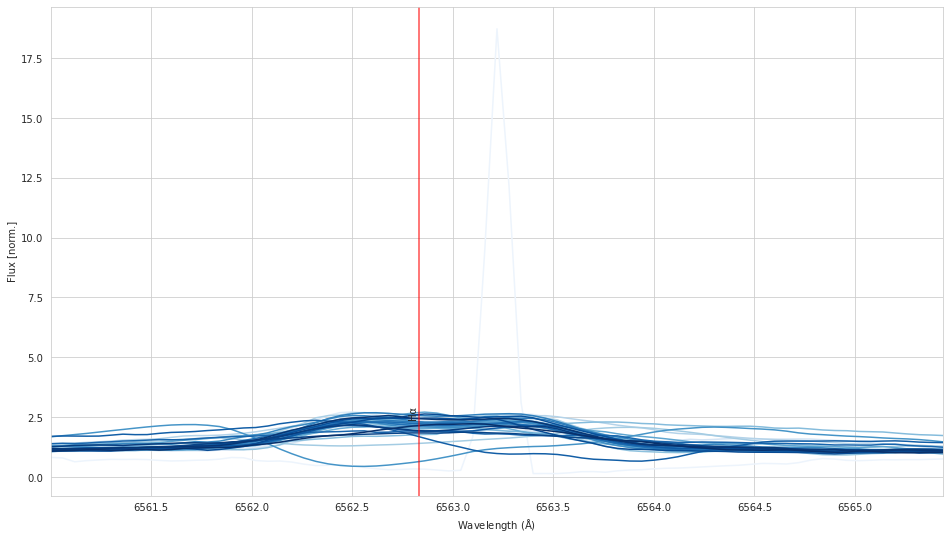

In [235]:
CLASS = 2
df_masked_label = df_masked.loc[df_masked["label"]==CLASS]
print(df_masked_label.index)
ax = (df_masked.loc[df_masked['label'] == CLASS].drop(columns=['label','sobject_id']).T).plot(
    legend=False, 
    xlabel = "Wavelength ($\mathrm{\AA}$)", 
    ylabel = "Flux [norm.]",
    #xticks = wl_grid[PLOT_MASK],
    xlim = (wl_grid[PLOT_MASK].min(),wl_grid[PLOT_MASK].max()),
    colormap = "Blues"
    )
halpha_line = ax.axvline(x=6562.83, color='red', label="coral", alpha=0.7)
ax.text(6562.78,2.5,"Hα", rotation=90)

#5293 is the errant inverse P-Cygni
#cross match against catalogs
#does it exist in the ctalog 
#4169 - get simbad 
#checknebular emissions flag 

In [28]:
df_masked.loc[6314,:"sobject_id"].astype(str)

sobject_id    170509005701009.0
Name: 6314, dtype: object

In [29]:
df_galah_xmatch = pd.read_csv("/home/pravn/Dropbox/Masters/Research Data/galah_cross_match_cotar_halpha.csv", index_col=0)

In [30]:
df_galah_xmatch.describe()

,sobject_id,teff,e_teff,logg,e_logg,fe_h,e_fe_h,ra,dec
count,6.977000e+03,6950.000000,6705.000000,6950.000000,6698.000000,6545.000000,6545.000000,6977.000000,6977.000000
mean,1.616289e+14,5139.345976,109.602959,3.539483,0.253855,-0.316575,0.118258,180.891237,-32.366215
std,1.397541e+13,879.361801,33.313305,1.153190,0.267788,0.442161,0.090321,88.614490,26.318101
min,1.311160e+14,3000.000000,69.206193,-0.168599,0.173703,-3.012563,0.040890,0.030946,-84.323031
25%,1.504290e+14,4535.756375,88.241313,3.214398,0.186346,-0.511067,0.077588,100.724401,-51.962669
50%,1.606020e+14,5186.099500,101.528847,4.016438,0.194462,-0.227451,0.101047,183.289243,-33.423923
75%,1.705170e+14,5795.674825,120.340241,4.288074,0.221513,-0.025331,0.137179,252.087808,-11.710908
max,1.902250e+14,7919.964400,475.931817,4.999198,5.242234,1.000000,4.885604,359.955743,27.358892


In [31]:
df_masked.describe()

,sobject_id,6561.00000000059,6561.060000000591,6561.120000000591,6561.1800000005915,6561.240000000592,6561.300000000592,6561.360000000593,6561.420000000593,6561.4800000005935,...,6564.960000000617,6565.020000000617,6565.0800000006175,6565.140000000618,6565.200000000618,6565.260000000619,6565.320000000619,6565.3800000006195,6565.44000000062,label
count,6.977000e+03,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,...,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000,6977.000000
mean,1.616289e+14,0.904588,0.906002,0.905649,0.905211,0.905907,0.905614,0.904135,0.901653,0.898647,...,0.897555,0.899959,0.902821,0.906731,0.910561,0.913475,0.915050,0.914227,0.910940,2.105203
std,1.397541e+13,0.133512,0.142865,0.139936,0.131953,0.140749,0.148470,0.148177,0.144318,0.145141,...,0.121121,0.110225,0.105232,0.104657,0.103950,0.103511,0.102874,0.101552,0.098488,1.442951
min,1.311160e+14,0.527667,0.517830,0.529720,0.534370,0.534563,0.520993,0.491913,0.466548,0.462708,...,0.455082,0.454815,0.459259,0.472829,0.489785,0.498759,0.497193,0.497910,0.510483,0.000000
25%,1.504290e+14,0.812355,0.811005,0.809272,0.805143,0.802104,0.797857,0.794502,0.789931,0.786138,...,0.821944,0.826380,0.829562,0.832342,0.835580,0.838515,0.839928,0.842135,0.842926,1.000000
50%,1.606020e+14,0.902828,0.905016,0.905128,0.905601,0.905044,0.903027,0.900594,0.896900,0.893057,...,0.898538,0.901606,0.907973,0.914628,0.915276,0.915382,0.915226,0.913011,0.910536,2.000000
75%,1.705170e+14,0.994714,0.998298,1.000629,1.002678,1.003761,1.004477,1.004483,1.006402,1.004958,...,0.972695,0.974744,0.977830,0.981786,0.988399,0.989596,0.987792,0.982393,0.974352,3.000000
max,1.902250e+14,4.493397,6.576160,6.203987,3.265955,4.704729,5.226535,4.510861,2.915056,2.113648,...,5.653857,3.561712,2.617017,2.612042,2.438605,2.115408,1.800835,1.967850,2.113697,9.000000


In [32]:
df_merged = pd.merge(df_masked, df_galah_xmatch, on="sobject_id")

In [33]:
df_merged.head()

,sobject_id,6561.00000000059,6561.060000000591,6561.120000000591,6561.1800000005915,6561.240000000592,6561.300000000592,6561.360000000593,6561.420000000593,6561.4800000005935,...,label,star_id,teff,e_teff,logg,e_logg,fe_h,e_fe_h,ra,dec
0,131116000501262,0.791232,0.799116,0.798513,0.789936,0.770570,0.747840,0.750200,0.778579,0.805557,...,1,03303061-6824089,5848.8174,109.977853,4.243084,0.184408,-0.338275,0.134476,52.627905,-68.402358
1,131116001001379,1.016790,1.033717,1.039141,1.053989,1.071330,1.068635,1.053506,1.034933,1.029725,...,2,04315418-5613335,4328.7964,118.017575,3.327391,0.198075,0.169383,0.128575,67.975753,-56.225897
2,131118002401234,1.068419,1.064418,1.059543,1.045539,1.045996,1.074062,1.101389,1.097221,1.074829,...,4,04303269-5730244,3136.7622,NaN,4.396316,NaN,NaN,NaN,67.635947,-57.506949
3,131118002401396,0.854523,0.876311,0.909512,0.926363,0.935885,0.954685,0.921646,0.926053,0.934858,...,2,04354318-5738560,4815.8853,140.982633,3.473381,0.215505,-0.916787,0.134253,68.930000,-57.648952
4,131118002901052,0.958085,0.961354,0.958334,0.960897,0.960540,0.954966,0.951380,0.939908,0.923267,...,2,05292291-5823105,5056.8890,84.699254,3.586107,0.183447,-0.459082,0.065107,82.345409,-58.386368


In [34]:
df_merged["star_id"].value_counts().loc[lambda x : x>0] 

03303061-6824089    1
13535153-7855400    1
17323823-5312361    1
15283143-2930494    1
03554351+1751252    1
                   ..
07172315-4301153    1
04374811-0550357    1
07172210-4303112    1
07172256-4311227    1
06085605-5620364    1
Name: star_id, Length: 6977, dtype: int64

In [35]:
df_merged.to_csv("/home/pravn/Dropbox/Masters/Research Data/results.csv")

In [36]:
#This is a test curve fit 

In [36]:
Y = df_masked.loc[6318,6561.00000000059:6565.44000000062].values

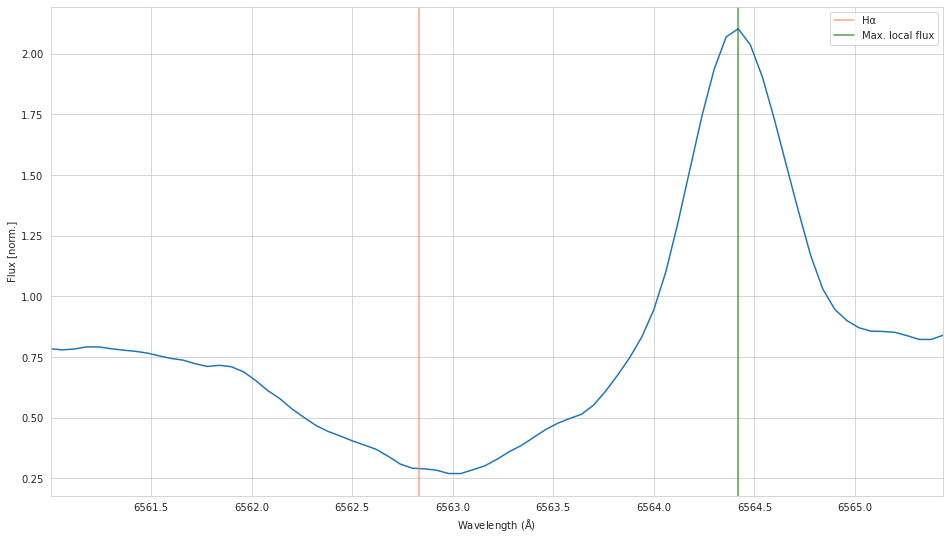

In [37]:
plt.plot(wl_grid[PLOT_MASK], Y)
plt.axvline(x=6562.83, color='coral', label="Hα", alpha=0.7)
plt.axvline(x=wl_grid[PLOT_MASK][np.argmax(Y)], color='green', label="Max. local flux",alpha=0.7)
plt.xlabel("Wavelength ($\mathrm{\AA}$)", size=10)
plt.ylabel("Flux [norm.]", size=10)
plt.xlim(wl_grid[PLOT_MASK].min(), wl_grid[PLOT_MASK].max())
plt.legend()

In [39]:
def double_gaussian(x, a1, b1, c1, a2, b2, c2):
    return a1*np.exp(-np.power(x - b1, 2)/(2*np.power(c1, 2))) + d1 + a2*np.exp(-np.power(x - b2, 2)/(2*np.power(c2, 2)))

In [40]:
from scipy.optimize import curve_fit

In [61]:
pars, cov = curve_fit(f=double_gaussian, xdata=wl_grid[PLOT_MASK], ydata=Y, p0=[0.4, wl_grid[PLOT_MASK][np.argmin(Y)], 0.1, 1.2, wl_grid[PLOT_MASK][np.argmax(Y)], 0.001, 0.6], 
bounds=((-np.inf,-np.inf,-np.inf,-np.inf,-np.inf,-np.inf, -np.inf),(np.inf,np.inf,np.inf,np.inf,np.inf,np.inf, np.inf)))

/home/pravn/anaconda3/envs/masters-thesis/lib/python3.8/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [62]:
a1 = pars[0]
b1 = pars[1]
c1 = pars[2]
a2 = pars[3]
b2 = pars[4]
c2 = pars[5]
d1 = pars[6]

In [63]:
x = wl_grid[PLOT_MASK]

In [64]:
Y_fit = a1*np.exp(-np.power(x - b1, 2)/(2*np.power(c1, 2))) + a2*np.exp(-np.power(x - b2, 2)/(2*np.power(c2, 2))) + d1

In [65]:
f1 = a1*np.exp(-np.power(x - b1, 2)/(2*np.power(c1, 2))) + d1
f2 = a2*np.exp(-np.power(x - b2, 2)/(2*np.power(c2, 2))) 

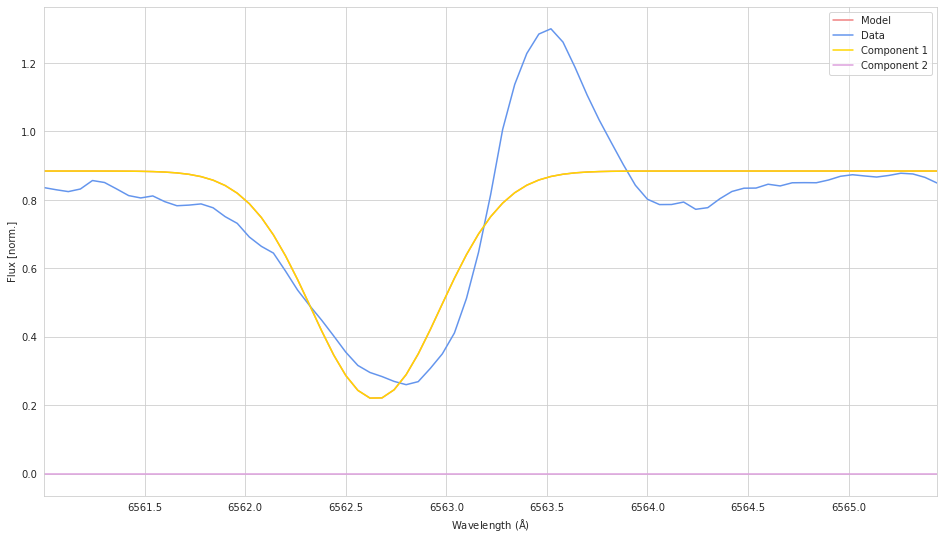

In [66]:
plt.plot(x, Y_fit, color='lightcoral', label="Model")
plt.plot(x, Y, color='cornflowerblue', label="Data")
plt.plot(x, f1, color='gold', label="Component 1")
plt.plot(x, f2, color='plum', label="Component 2")
#plt.axvline(x=6562.83, color='coral', label="Hα", alpha=0.7)
#plt.axvline(x=wl_grid[PLOT_MASK][np.argmax(Y)], color='green', label="Max. local flux",alpha=0.7)
plt.xlabel("Wavelength ($\mathrm{\AA}$)", size=10)
plt.ylabel("Flux [norm.]", size=10)
plt.xlim(wl_grid[PLOT_MASK].min(), wl_grid[PLOT_MASK].max())
plt.legend()